In [0]:
%matplotlib inline
import cv2
import os
import sys
import glob
import keras
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras import optimizers
from keras.applications.vgg16 import preprocess_input
from keras.layers import Dense, Flatten, Input, Activation, add
from keras.models import Sequential, Model
from keras.preprocessing import image as IMG
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg16 import VGG16

from PIL import Image

from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    Resize,
    CenterCrop,
    RandomCrop,
    Crop,
    Compose
)

import xml.etree.ElementTree as ET 

In [0]:
# colab用
#!mkdir -p cat_dog/train/dog cat_dog/train/cat
#!mkdir -p cat_dog/test/dog cat_dog/test/cat
#!mkdir annotation_xml

## 【問題1】自作データセットでの分類の学習
## 【問題2】分類データセットに対するデータ拡張

In [118]:
# 分類
classes = ['dog', 'cat']

image_width, image_height = 224, 224

# datasetディレクトリ
dataset_path = 'cat_dog'

train_data_path = str(dataset_path) + '/train'  
test_data_path = str(dataset_path) + '/test' 

# 重みデータを保存するディレクトリ
result_dir = '.'

# データの枚数
train_data_count = 20
validation_data_count = 4

# バッチサイズ、エポック数
batch_size = 4
epoch_count = 10

# データ拡張
datagen = ImageDataGenerator(
    rescale = 1.0/255,               # 正規化
    width_shift_range=0.2,      # ランダムに水平シフト
    height_shift_range=0.2,     # ランダムに垂直シフト
    shear_range=0.39,              # シアー強度
    horizontal_flip=True)           # 水平方向にランダム判定

generator_train = datagen.flow_from_directory(
    train_data_path,
    target_size=(image_width, image_height),
    color_mode='rgb',
    classes=classes,
    class_mode='binary', 
    batch_size=batch_size,
    shuffle=True)

generator_test = datagen.flow_from_directory(
    test_data_path,
    target_size=(image_width, image_height),
    color_mode='rgb',
    classes=classes,
    class_mode='binary', 
    batch_size=batch_size,
    shuffle=True)

Found 20 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [0]:
# VGG16学習済みモデルの読み込み(RGB)
input_tensor = Input(shape=(image_width, image_height, 3))
learned_model = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

# 全結合層の作成
full_model = Sequential()
full_model.add(Flatten(input_shape=learned_model.output_shape[1:]))
full_model.add(Dense(256, activation='relu',
                    kernel_initializer='he_normal'))
full_model.add(Dense(64, activation='relu',
                    kernel_initializer='he_normal'))
full_model.add(Dense(1, activation='sigmoid'))

# 学習済みデータと全結合層を結合
model = Model(inputs=learned_model.input, outputs=full_model(learned_model.output))

# 全結合層直前までの層を学習しないようにする
for layer in learned_model.layers[:15]:
    layer.trainable = False

# 学習処理の設定
model.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=optimizers.RMSprop(lr=1e-4),
    metrics=['accuracy'])

In [120]:
# 学習
result = model.fit_generator(
    generator_train,
    steps_per_epoch=train_data_count,
    epochs=epoch_count)

# 重みを保存
model.save_weights(os.path.join(result_dir, 'weight.h5'))

Epoch 1/10
20/20 [==============================] - 2s 93ms/step - loss: 0.8153 - acc: 0.6000
Epoch 2/10
20/20 [==============================] - 1s 54ms/step - loss: 0.2770 - acc: 0.8500
Epoch 3/10
20/20 [==============================] - 1s 60ms/step - loss: 0.0836 - acc: 0.9750
Epoch 4/10
20/20 [==============================] - 1s 59ms/step - loss: 0.0332 - acc: 0.9875
Epoch 5/10
20/20 [==============================] - 1s 59ms/step - loss: 0.1908 - acc: 0.9750
Epoch 6/10
20/20 [==============================] - 1s 60ms/step - loss: 0.0053 - acc: 1.0000
Epoch 7/10
20/20 [==============================] - 1s 58ms/step - loss: 0.0415 - acc: 0.9750
Epoch 8/10
20/20 [==============================] - 1s 59ms/step - loss: 0.0025 - acc: 1.0000
Epoch 9/10
20/20 [==============================] - 1s 58ms/step - loss: 7.6029e-05 - acc: 1.0000
Epoch 10/10
20/20 [==============================] - 1s 58ms/step - loss: 9.2625e-06 - acc: 1.0000


In [121]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________



<<DOG>>

犬です
予測値 : [0.00016756]


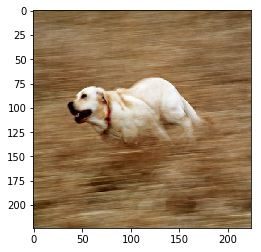

------------------------------------
犬です
予測値 : [0.0084247]


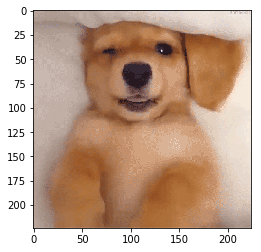

------------------------------------
猫です
予測値 : [0.99997187]


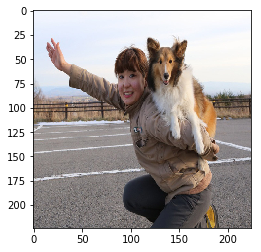

------------------------------------
犬です
予測値 : [0.00073511]


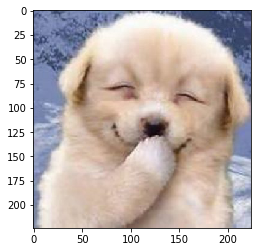

------------------------------------
犬です
予測値 : [9.222569e-05]


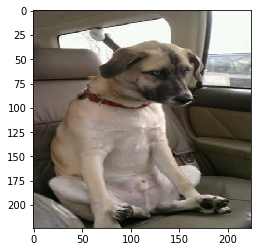

------------------------------------


<<CAT>>

犬です
予測値 : [0.00109518]


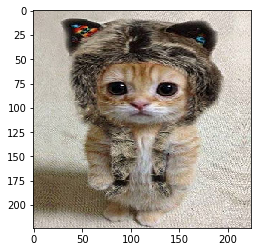

------------------------------------
猫です
予測値 : [0.6271897]


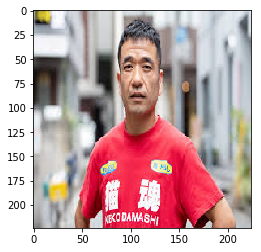

------------------------------------
猫です
予測値 : [0.99862075]


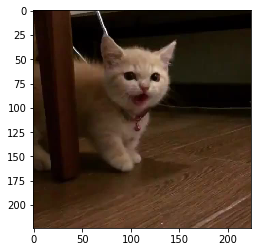

------------------------------------
猫です
予測値 : [0.99997914]


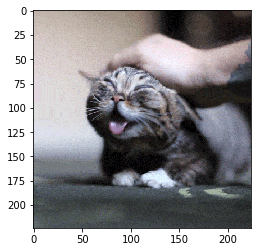

------------------------------------
猫です
予測値 : [0.9999995]


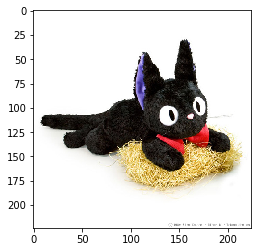

------------------------------------


In [124]:
def test_predict(filepath_list):

    for i in filepath_list:
        # 画像を読み込んで4次元テンソルへ変換
        img = IMG.load_img(i, target_size=(image_height, image_width))
        xarray = IMG.img_to_array(img)
        x = np.expand_dims(xarray, axis=0)
        # テストデータも正規化
        x = x / 255.0

        # 予測 入力は1枚の画像なので[0]のみ
        pred = model.predict(x)[0]
        if pred < 0.5:
          print('犬です')
          print('予測値 : {}'.format(pred))
        else:
          print('猫です')
          print('予測値 : {}'.format(pred))
        
        plt.imshow(img)
        plt.show()
        
        print('------------------------------------')

        
for x in classes:
    print('\n\n<<'+ str(x).upper() + '>>\n')
    filepath_list = glob.glob(str(test_data_path)  + '/' + str(x) + '/*')
    test_predict(filepath_list)

## 【問題3】物体検出データセットの用意
## 【問題4】物体検出データセットに対するデータ拡張


In [0]:
# albumentations インストール
#!pip install albumentations > /dev/null

In [0]:
# albumentations tutorialの実装を持ってくる
def download_image(url):
    data = urlopen(url).read()
    data = np.frombuffer(data, np.uint8)
    image = cv2.imdecode(data, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [0]:
# Functions to visualize bounding boxes and class labels on an image. 
# Based on https://github.com/facebookresearch/Detectron/blob/master/detectron/utils/vis.py

BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)


def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=2):
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img


def visualize(annotations, category_id_to_name):
    img = annotations['image'].copy()
    for idx, bbox in enumerate(annotations['bboxes']):
        img = visualize_bbox(img, bbox, annotations['category_id'][idx], category_id_to_name)
    Image.fromarray(img).save('hofge.jpg')
    plt.figure(figsize=(12, 12))
    plt.imshow(img)

In [0]:
def get_aug(aug, min_area=0., min_visibility=0.):
    return Compose(aug, bbox_params={'format': 'coco', 'min_area': min_area, 'min_visibility': min_visibility, 'label_fields': ['category_id']})

In [129]:
image = np.array(Image.open('cat_dog/train/dog/dog_001.jpg'))
print(image.shape)

(400, 300, 3)


In [133]:
# XMLファイルを解析
tree = ET.parse('annotation_xml/dog_001.xml') 

# XMLを取得
root = tree.getroot()
bbox = np.array([])

for i in range(4):
  coodinate = int(root[6][4][i].text)
  bbox = np.append(bbox, coodinate)
  
# バウンディングボックスを作るのをサボったためちょっとだけチート
bbox[2] = 240
bbox[3] = 340

print(bbox)

[ 46.  55. 240. 340.]


In [0]:
# Annotations for image 386298 from COCO http://cocodataset.org/#explore?id=386298
annotations = {'image': image, 'bboxes': [bbox], 'category_id': [18]}
category_id_to_name = {18: 'dog'}

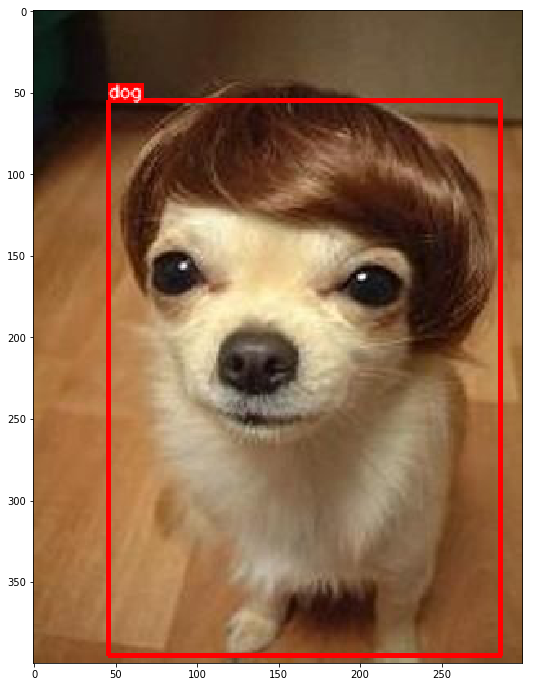

In [135]:
visualize(annotations, category_id_to_name)

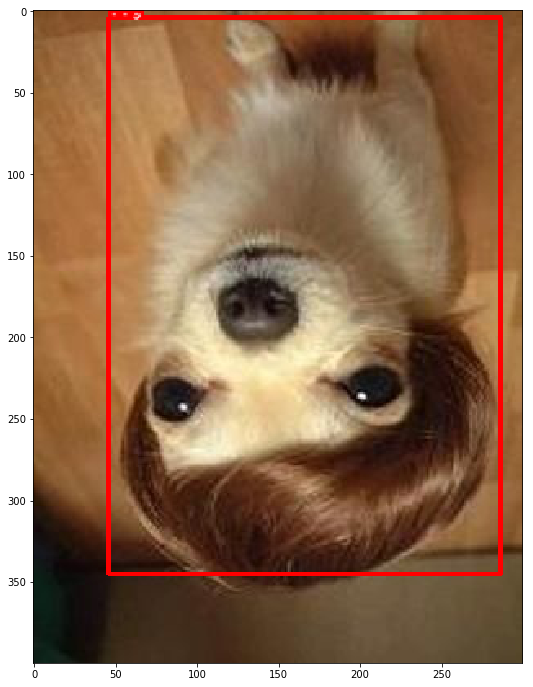

In [136]:
aug = get_aug([VerticalFlip(p=1)])
augmented = aug(**annotations)
visualize(augmented, category_id_to_name)

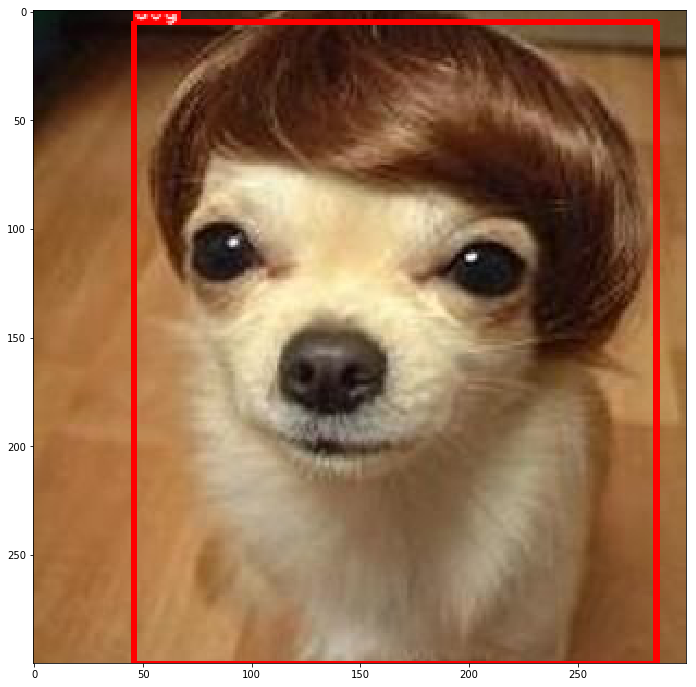

In [137]:
# Compose filters bounding boxes and returns
# only those boxes whose visibility after transformation is above the threshold.
aug = get_aug([CenterCrop(p=1, height=300, width=300)], min_visibility=0.3)
augmented = aug(**annotations)
visualize(augmented, category_id_to_name)

# Visibility of the transformed bbox for `dog` is about 0.25 (that means that
# the area of the transformed bbox is about 25% of the area of the original bbox),
# so it will be removed
# Visibility of the transformed bbox for `cat` is about 0.36,
# so it will be kept.